In [ ]:
# Warning: You must have LaTeX installed

[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

# Farnebäck's motion estimation

Farnebäck estimates the dense (1x1) optical flow (with subpixel accuracy) assuming that the frames are similar in texture and the motion is smooth. In general, this last requirement generates motion fields more visually coherent and smoother that in the case of block-based ME algorithms.

In [4]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [5]:
!which python

/shared/PEs/farneback-python/bin/python


In [6]:
!pip install --upgrade pip

In [7]:
try:
    import scipy
except:
    !pip install scipy
    import scipy

In [8]:
try:
    import skimage
except:
    !pip install scikit-image
    import skimage

In [9]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [10]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [11]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

In [12]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

In [13]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

In [14]:
try:
    import optical_flow as motion
    import display
    import prediction
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    from motion_estimation import optical_flow as motion
    from motion_estimation import display
    from motion_estimation import prediction

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5
extension mode = 1


In [15]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [16]:
%%bash
if [ -d "$HOME/repos/image_synthesis" ]; then
    cd $HOME/repos/image_synthesis
    echo "$HOME/repos/image_synthesis ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_synthesis.git
fi

/home/vruiz/repos/image_synthesis ... 
Already up to date.


## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but transform coefficients resulting of convolving the following basis fuctions. This decreases the computational requirements the algorithm.

### No motion

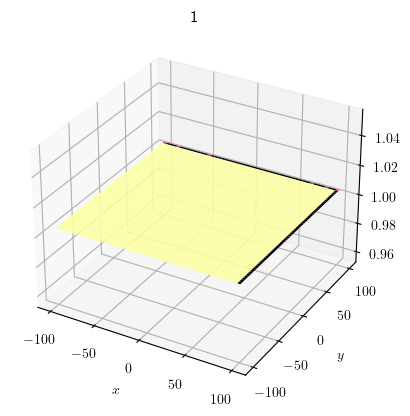

In [17]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

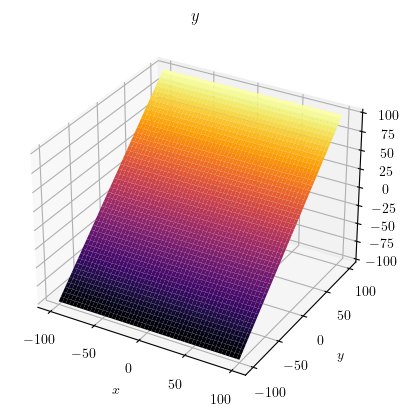

In [18]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

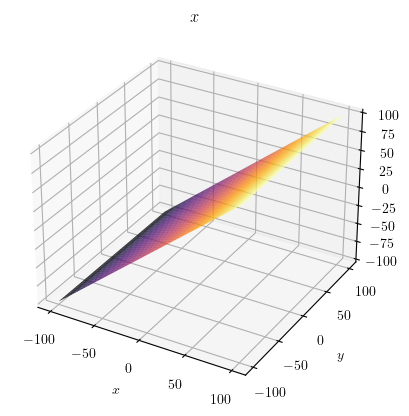

In [19]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

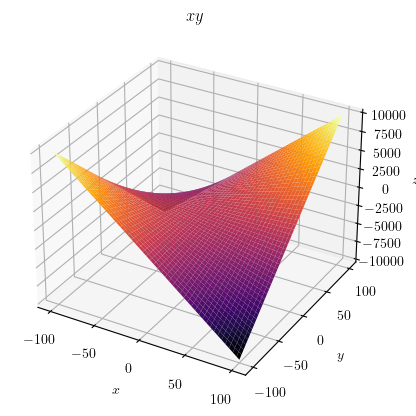

In [20]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

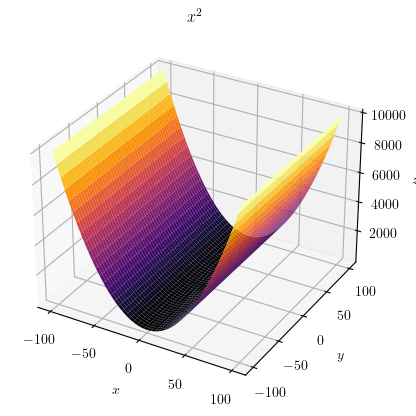

In [21]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

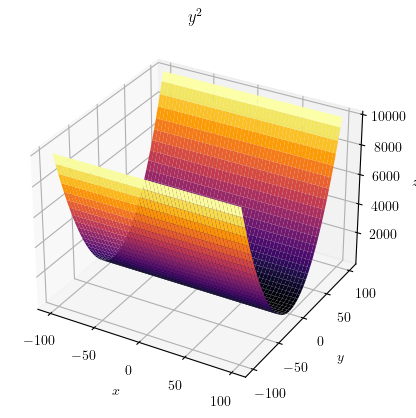

In [22]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Create a moving-circles sequence
There are two circles, moving horizontally in oposite directions.

In [23]:
%%bash
frames=5
~/repos/image_synthesis/moving_circle.sh -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f $frames -d 10
~/repos/image_synthesis/moving_circle.sh -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f $frames -d 10 -a 0 -b -1
set -x
i=0
while [ $i -le $((frames-1)) ]
do
    ii=$(printf "%03d" $i)
    convert -append /tmp/right${ii}.png /tmp/left${ii}.png /tmp/${ii}.png
    i=$(( $i + 1 ))
done
set -x

/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f 5 -d 10
output = /tmp/right
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/right000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 33,16 43,16' -depth 8 /tmp/right001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 34,16 44,16' -depth 8 /tmp/right002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 35,16 45,16' -depth 8 /tmp/right003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 36,16 46,16' -depth 8 /tmp/right004.png
+ i=5
+ '[' 5 -le 4 ']'


/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f 5 -d 10 -a 0 -b -1
output = /tmp/left
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10
Y increment = 0
X increment = -1


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/left000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 31,16 41,16' -depth 8 /tmp/left001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 30,16 40,16' -depth 8 /tmp/left002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 29,16 39,16' -depth 8 /tmp/left003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 28,16 38,16' -depth 8 /tmp/left004.png
+ i=5
+ '[' 5 -le 4 ']'
+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -append /tmp/right000.png /tmp/left000.png /tmp/000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001


## Testing with moving circles (max_abs_motion=1)

In [24]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/001.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=672 max=255 min=0
[image_3.py:39 read() INFO] /tmp/001.png (64, 64, 3) uint8 len=672 max=255 min=0


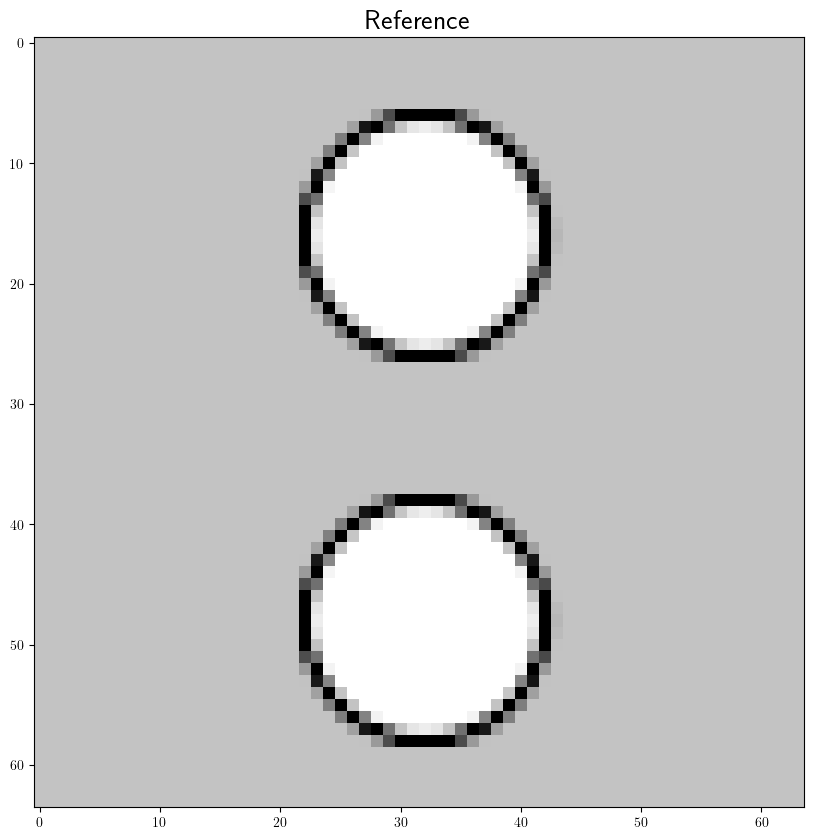

In [25]:
gray_image.show(R_Y, "Reference")

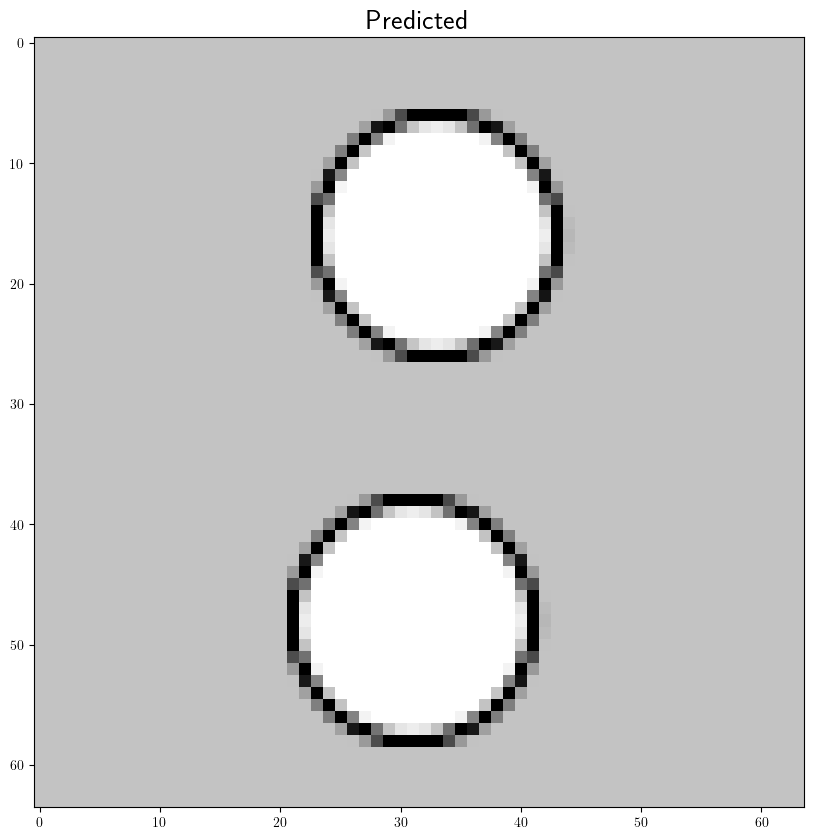

In [26]:
gray_image.show(P_Y, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [27]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

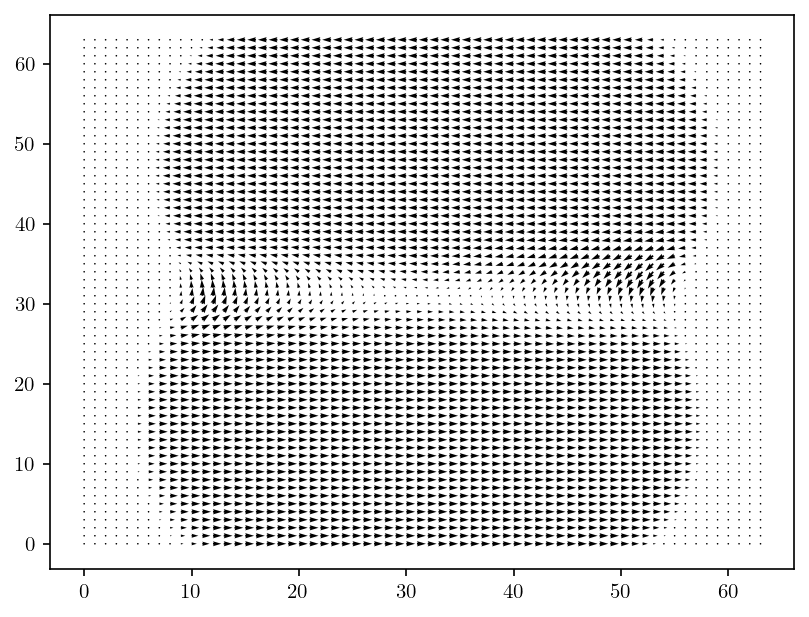

In [28]:
display.show_vectors(MVs[::1, ::1])

In [29]:
hat_P = prediction.make(reference=R, MVs=MVs)

In [30]:
print(R.dtype, MVs.dtype)

uint8 float32


[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.75390625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.47607421875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.46240234375
[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.740234375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.457275390625
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.440673828125
[image_3.py:87 print_stats() INFO] component=0 max=132 min=125 avg=128.013671875
[image_3.py:87 print_stats() INFO] component=1 max=134 min=123 avg=128.018798828125
[image_3.py:87 print_stats() INFO] component=2 max=135 min=123 avg=128.021728515625


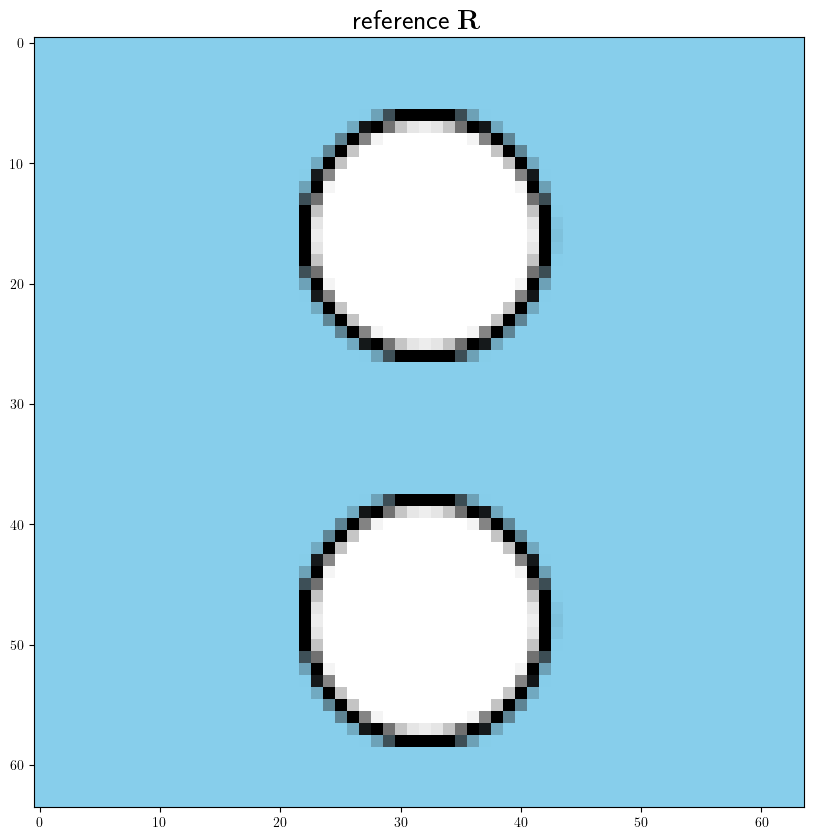

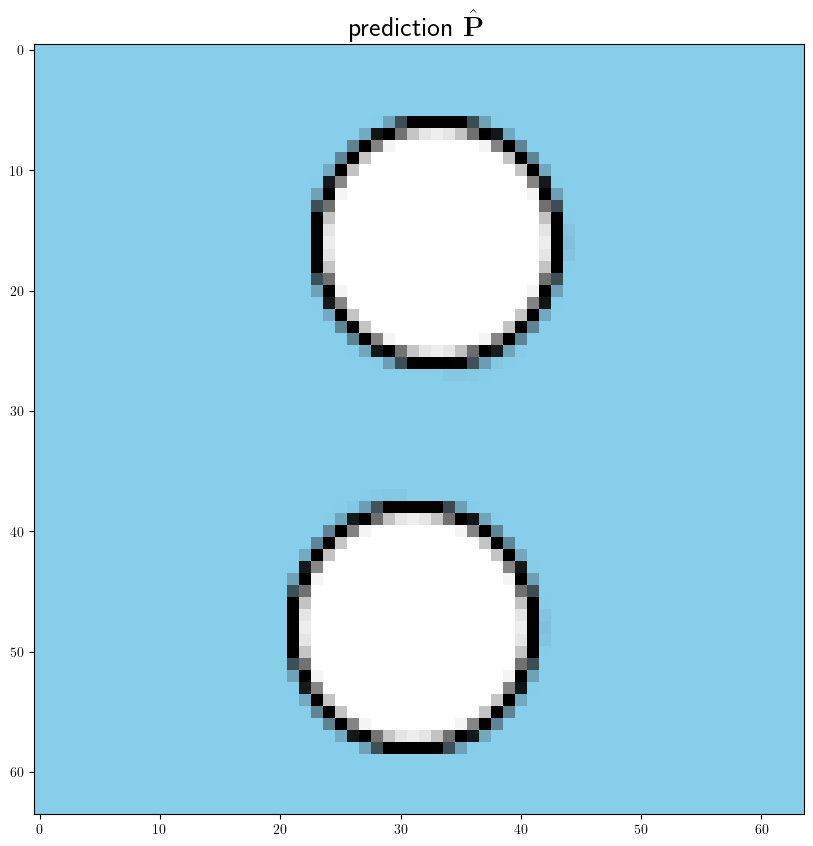

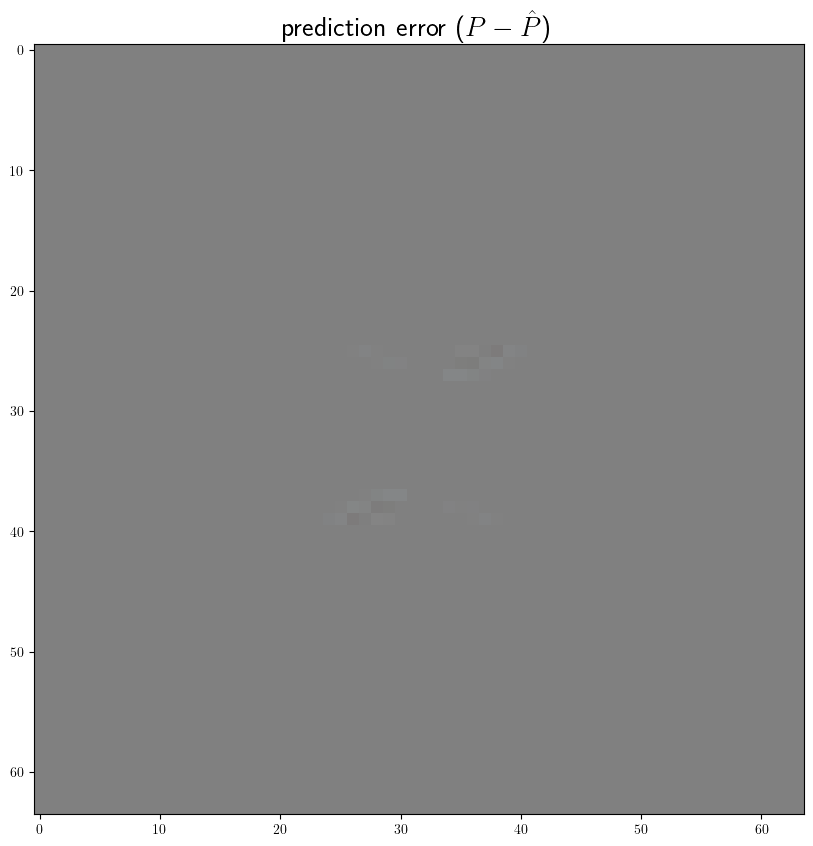

In [31]:
RGB_image.show(R, "reference ${\mathbf R}$")
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Testing with moving circles (max_abs_motion=2)

In [32]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/002.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=672 max=255 min=0
[image_3.py:39 read() INFO] /tmp/002.png (64, 64, 3) uint8 len=672 max=255 min=0


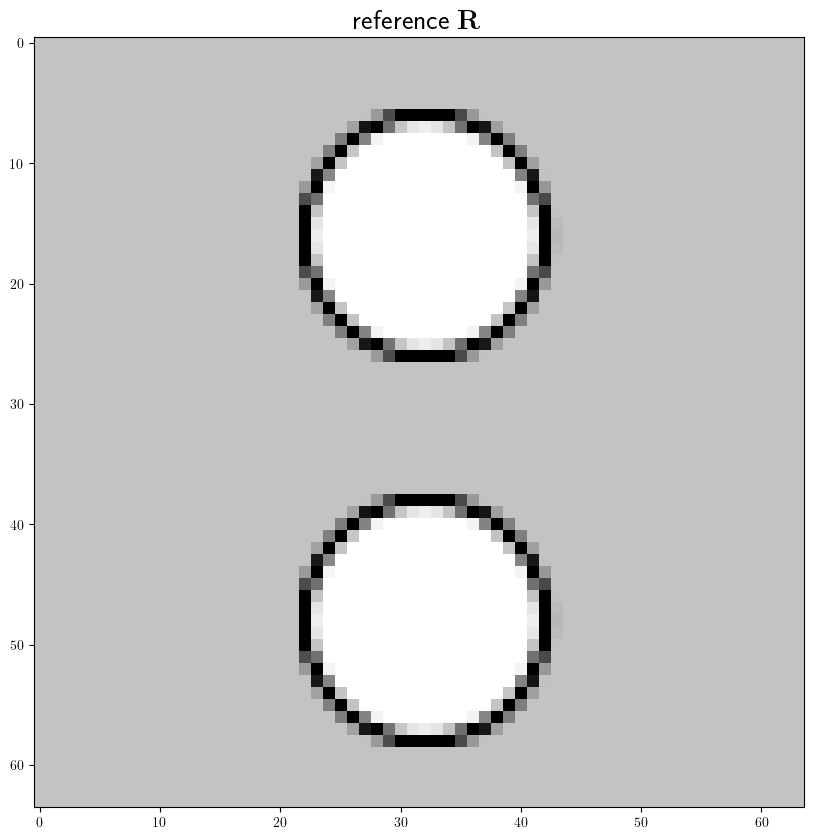

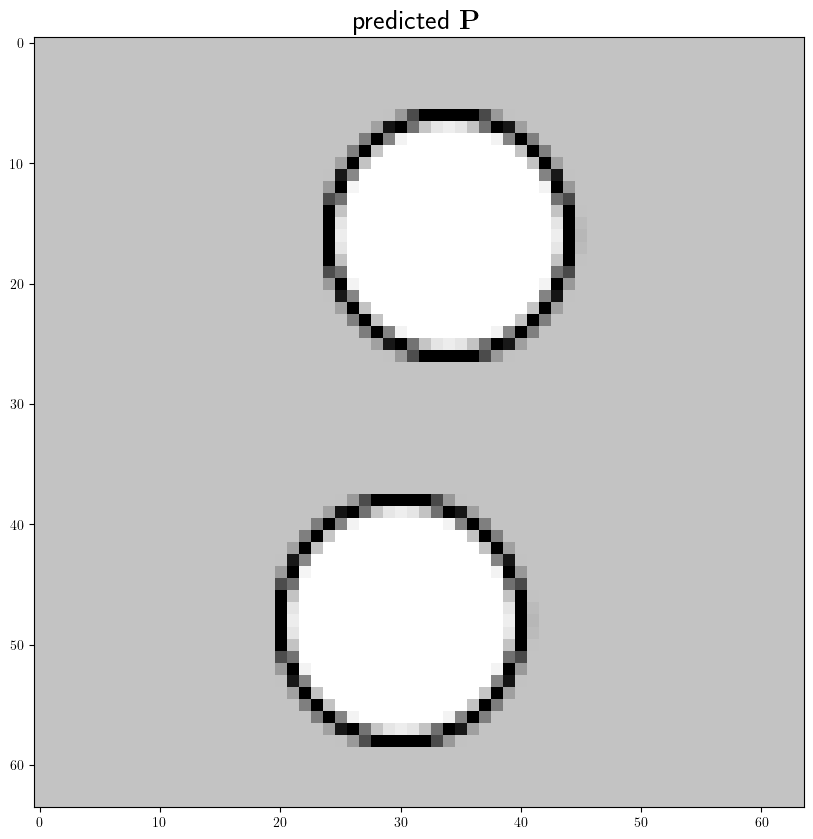

In [33]:
gray_image.show(R_Y, "reference ${\mathbf R}$")
gray_image.show(P_Y, "predicted ${\mathbf P}$")

In [34]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

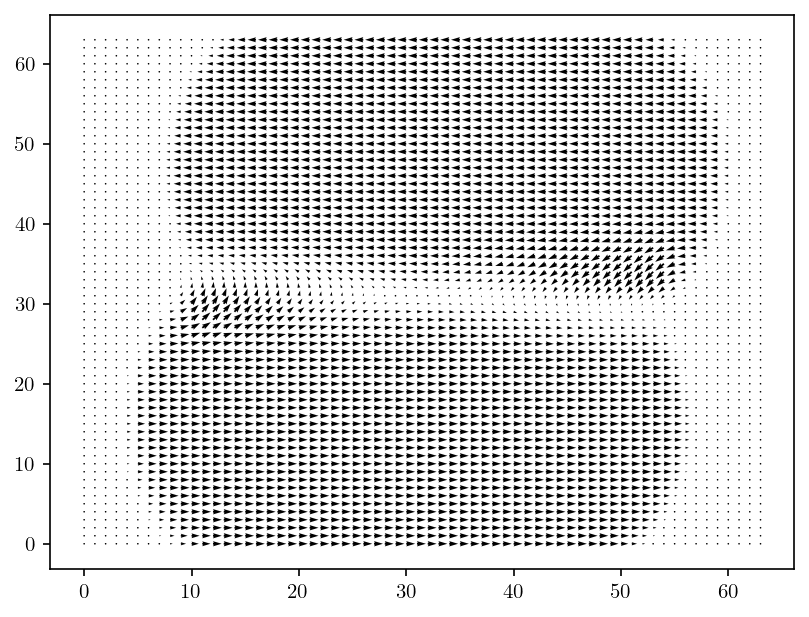

In [35]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.752197265625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.46337890625
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.443115234375
[image_3.py:87 print_stats() INFO] component=0 max=136 min=118 avg=128.001708984375
[image_3.py:87 print_stats() INFO] component=1 max=140 min=117 avg=128.0126953125
[image_3.py:87 print_stats() INFO] component=2 max=142 min=117 avg=128.019287109375


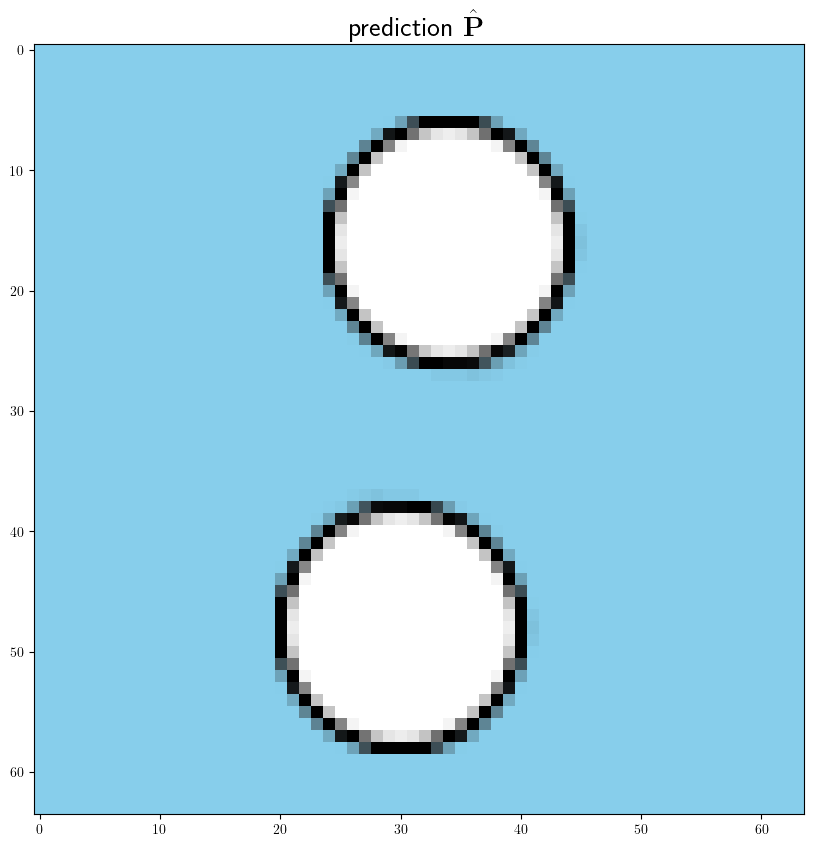

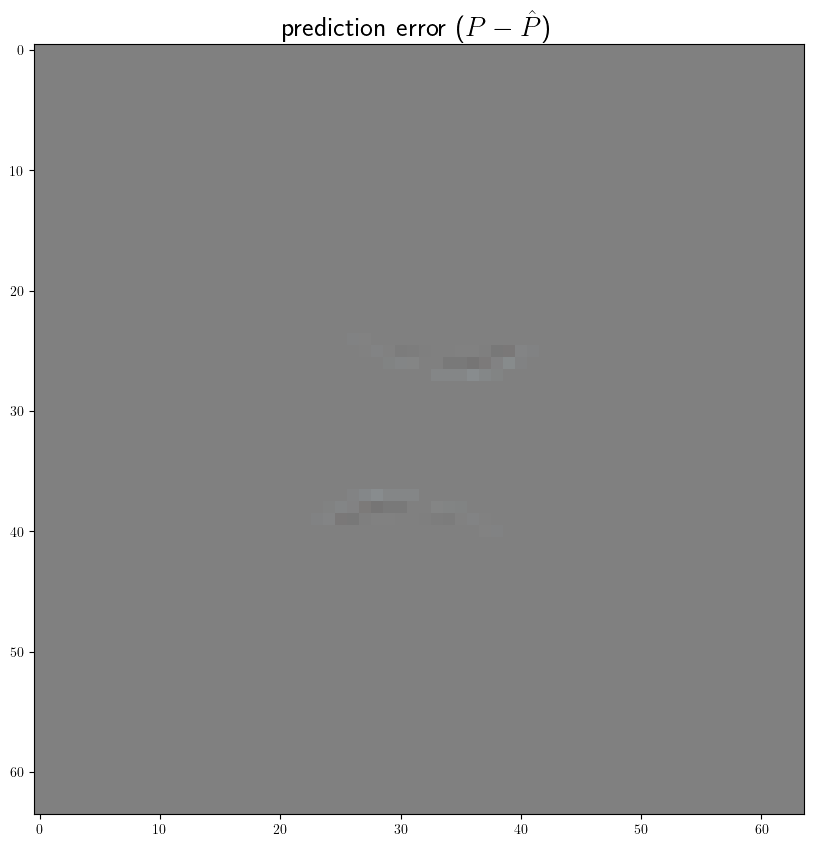

In [36]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Even more distance

In [37]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/004.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=672 max=255 min=0
[image_3.py:39 read() INFO] /tmp/004.png (64, 64, 3) uint8 len=672 max=255 min=0


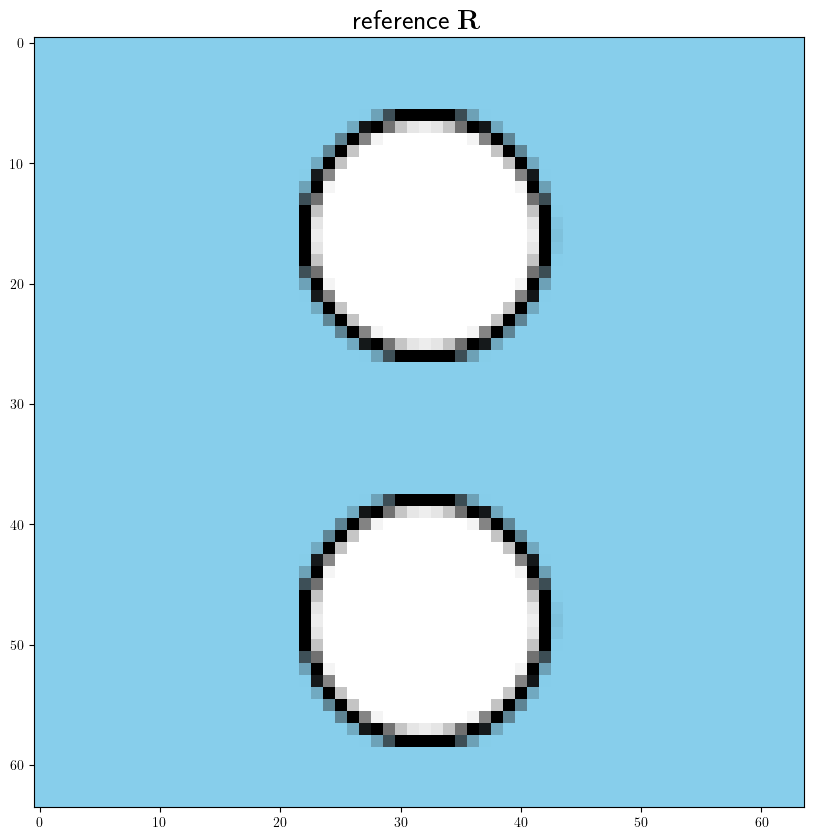

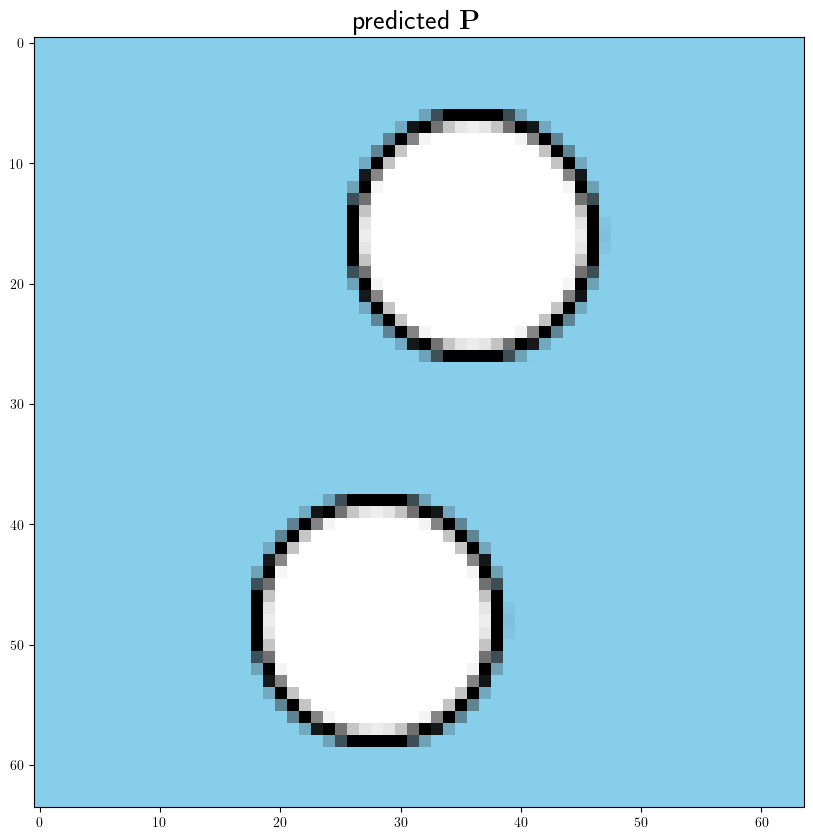

In [38]:
gray_image.show(R, "reference ${\mathbf R}$")
gray_image.show(P, "predicted ${\mathbf P}$")

In [39]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

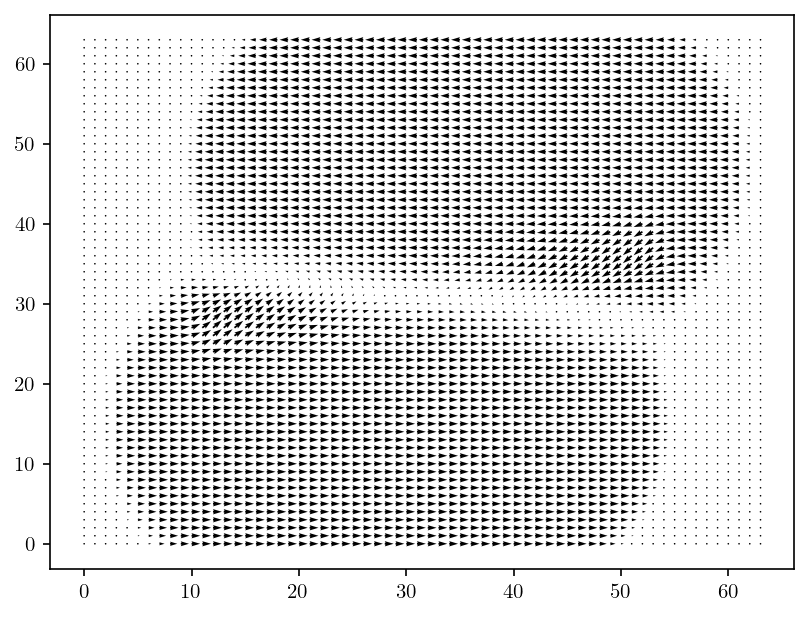

In [40]:
display.show_vectors(MVs[::1, ::1])

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.74853515625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.44677734375
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.42138671875
[image_3.py:87 print_stats() INFO] component=0 max=141 min=111 avg=128.00537109375
[image_3.py:87 print_stats() INFO] component=1 max=147 min=109 avg=128.029296875
[image_3.py:87 print_stats() INFO] component=2 max=150 min=109 avg=128.041015625


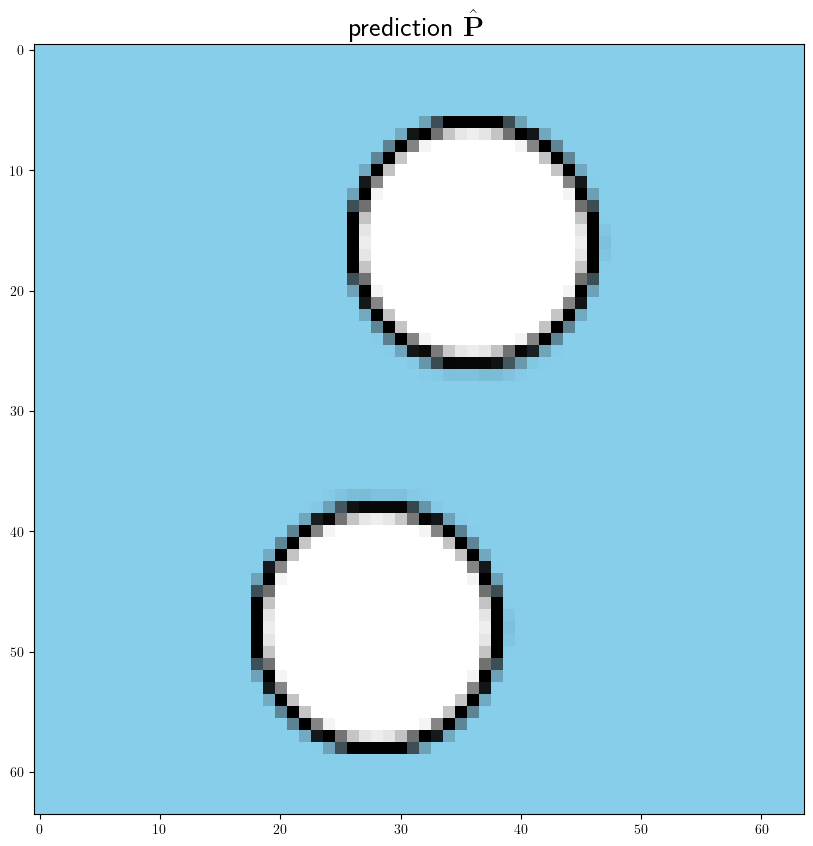

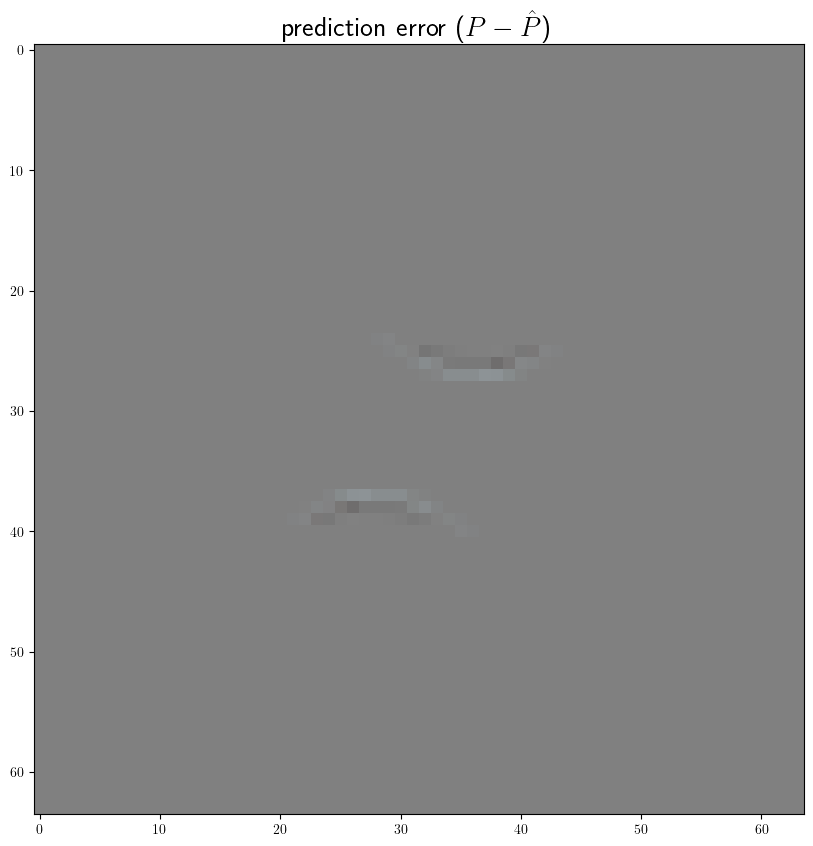

In [41]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

### Conclusion
Farnebäck's ME does not always minimizes the L$_2$ distance.

## Tile of Stockholm

In [42]:
%%bash
URL="https://hpca.ual.es/~vruiz/videos/"
sequence="stockholm_1280x768x50x420x578.avi"
output_prefix="/tmp/original_"
number_of_frames=16
first_frame=2
~/repos/image_synthesis/extract_frames.sh -u $URL -s $sequence -o $output_prefix -n $number_of_frames -f $first_frame

URL = https://hpca.ual.es/~vruiz/videos/
sequence file name = stockholm_1280x768x50x420x578.avi
output prefix = /tmp/original_
number of frames to extract = 16
first frame to extract = 2
/tmp/stockholm_1280x768x50x420x578.avi exists. Only extracting ...


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [43]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
sequence = "/tmp/original_"
R = RGB_image.read(sequence + "003.png")[slice_Y, slice_X]
P = RGB_image.read(sequence + "004.png")[slice_Y, slice_X]

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:39 read() INFO] /tmp/original_004.png (768, 1280, 3) uint8 len=1928644 max=255 min=0


In [44]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [45]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

In [46]:
MVs.dtype

dtype('float32')

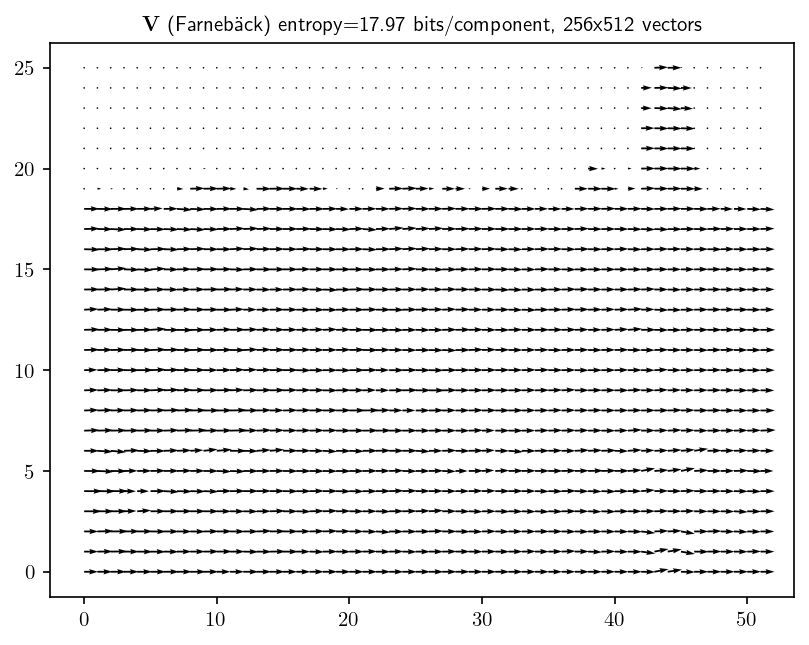

In [47]:
entropy = information.entropy(MVs.flatten())
display.show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

[image_3.py:87 print_stats() INFO] component=0 max=254 min=0 avg=108.20100402832031
[image_3.py:87 print_stats() INFO] component=1 max=243 min=0 avg=93.01155090332031
[image_3.py:87 print_stats() INFO] component=2 max=232 min=0 avg=76.66618347167969
[image_3.py:87 print_stats() INFO] component=0 max=227 min=10 avg=127.9944076538086
[image_3.py:87 print_stats() INFO] component=1 max=248 min=43 avg=128.05745697021484
[image_3.py:87 print_stats() INFO] component=2 max=244 min=69 avg=127.90385437011719


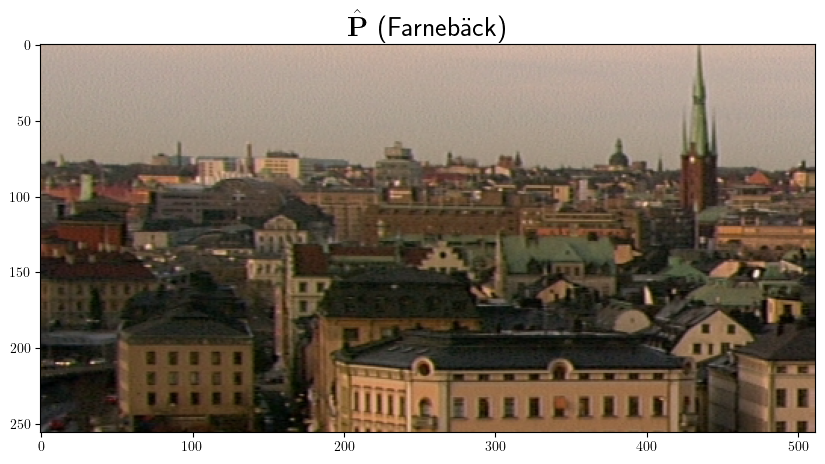

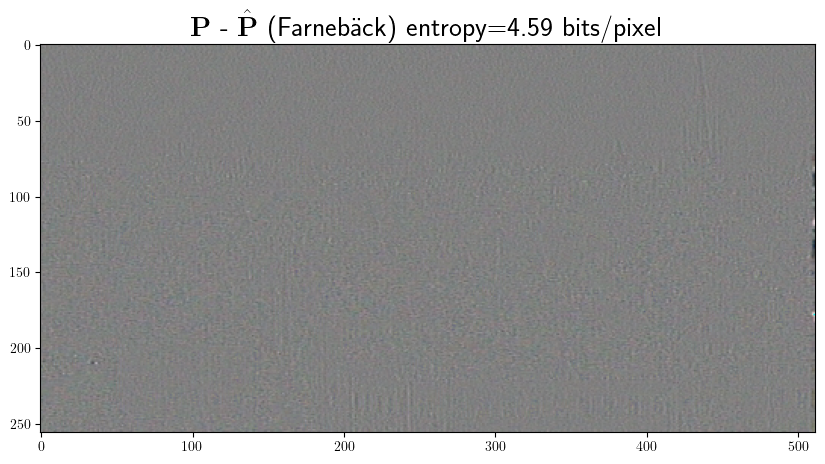

In [48]:
hat_P = prediction.make(R, MVs)
RGB_image.show(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
RGB_image.show(P_hat_P.astype(np.uint8), "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")

Notice that Farneback provides subpixel accuracy.

## Another implementation
https://github.com/ericPrince/optical-flow/blob/master/optical_flow.py

In [49]:
import numpy as np
import scipy.ndimage
from functools import partial
import skimage.io
import skimage.transform

__all__ = ["__version__", "poly_exp", "flow_iterative"]


__version__ = "1.0.0"


def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback
    Uses separable normalized correlation
    $f ~ x^T A x + B^T x + C$
    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", )
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]
    print("a =", a)

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack(
        [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
    )
    print("bx =", bx)
    by = np.stack(
        [
            np.ones(a.shape),
            np.ones(a.shape),
            x,
            np.ones(a.shape),
            x**2,
            x,
        ],
        axis=-1,
    )
    print("by =", by)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("c =", c)
    print("f =", f)
    print("cf =", cf)

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, bx)
    abb = np.einsum("ij,ik->ijk", ab, bx)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, by)
    abb = np.einsum("ij,ik->ijk", ab, by)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab[..., i], axis=1, mode="constant", cval=0
        )

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f
    print("A =", A)
    print("B =", B)
    print("C =", C)
    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)

    return A, B, C


def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(
        np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])),
        axis=-1,
    ).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
          
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

def OF(f1, f2): # f1 and f2 double's
    # certainties for images - certainty is decreased for pixels near the edge
    # of the image, as recommended by Farneback

    # c1 = np.ones_like(f1)
    # c2 = np.ones_like(f2)

    c1 = np.minimum(
        1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
    )
    c1 = np.minimum(
        c1,
        1
        / 5
        * np.minimum(
            f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
            f1.shape[1] - 1 - np.arange(f1.shape[1]),
        ),
    )
    c2 = c1

    # ---------------------------------------------------------------
    # calculate optical flow with this algorithm
    # ---------------------------------------------------------------

    n_pyr = 4

    # # version using perspective warp regularization
    # # to clean edges
    # opts = dict(
    #     sigma=4.0,
    #     sigma_flow=4.0,
    #     num_iter=3,
    #     model='eight_param',
    #     mu=None,
    # )

    # version using no regularization model
    opts = dict(
        sigma=4.0,
        sigma_flow=4.0,
        num_iter=3,
        model="constant",
        mu=0,
    )

    # optical flow field
    d = None

    # calculate optical flow using pyramids
    # note: reversed(...) because we start with the smallest pyramid
    for pyr1, pyr2, c1_, c2_ in reversed(
        list(
            zip(
                *list(
                    map(
                        partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                        [f1, f2, c1, c2],
                    )
                )
            )
        )
    ):
        if d is not None:
            # TODO: account for shapes not quite matching
            #d = skimage.transform.pyramid_expand(d, multichannel=True)
            d = skimage.transform.pyramid_expand(d, channel_axis=2)
            d = d[: pyr1.shape[0], : pyr2.shape[1]]

        d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

    xw = d + np.moveaxis(np.indices(f1.shape), 0, -1)
    return xw

In [50]:
MVs = OF(P_Y, R_Y)
f2_w = skimage.transform.warp(R_Y, np.moveaxis(MVs, -1, 0), cval=np.nan)

n = 17
x =
a = [1.19612884e-04 3.35462628e-04 8.83826307e-04 2.18749112e-03
 5.08606923e-03 1.11089965e-02 2.27941809e-02 4.39369336e-02
 7.95595087e-02 1.35335283e-01 2.16265167e-01 3.24652467e-01
 4.57833362e-01 6.06530660e-01 7.54839602e-01 8.82496903e-01
 9.69233234e-01 1.00000000e+00 9.69233234e-01 8.82496903e-01
 7.54839602e-01 6.06530660e-01 4.57833362e-01 3.24652467e-01
 2.16265167e-01 1.35335283e-01 7.95595087e-02 4.39369336e-02
 2.27941809e-02 1.11089965e-02 5.08606923e-03 2.18749112e-03
 8.83826307e-04 3.35462628e-04 1.19612884e-04]
bx = [[  1. -17.   1. 289.   1. -17.]
 [  1. -16.   1. 256.   1. -16.]
 [  1. -15.   1. 225.   1. -15.]
 [  1. -14.   1. 196.   1. -14.]
 [  1. -13.   1. 169.   1. -13.]
 [  1. -12.   1. 144.   1. -12.]
 [  1. -11.   1. 121.   1. -11.]
 [  1. -10.   1. 100.   1. -10.]
 [  1.  -9.   1.  81.   1.  -9.]
 [  1.  -8.   1.  64.   1.  -8.]
 [  1.  -7.   1.  49.   1.  -7.]
 [  1.  -6.   1.  36.   1.  -6.]
 [  1.  -5.   1.  25.   1.  -5.]
 [  1.  -4.   1.

n = 17
x =
a = [1.19612884e-04 3.35462628e-04 8.83826307e-04 2.18749112e-03
 5.08606923e-03 1.11089965e-02 2.27941809e-02 4.39369336e-02
 7.95595087e-02 1.35335283e-01 2.16265167e-01 3.24652467e-01
 4.57833362e-01 6.06530660e-01 7.54839602e-01 8.82496903e-01
 9.69233234e-01 1.00000000e+00 9.69233234e-01 8.82496903e-01
 7.54839602e-01 6.06530660e-01 4.57833362e-01 3.24652467e-01
 2.16265167e-01 1.35335283e-01 7.95595087e-02 4.39369336e-02
 2.27941809e-02 1.11089965e-02 5.08606923e-03 2.18749112e-03
 8.83826307e-04 3.35462628e-04 1.19612884e-04]
bx = [[  1. -17.   1. 289.   1. -17.]
 [  1. -16.   1. 256.   1. -16.]
 [  1. -15.   1. 225.   1. -15.]
 [  1. -14.   1. 196.   1. -14.]
 [  1. -13.   1. 169.   1. -13.]
 [  1. -12.   1. 144.   1. -12.]
 [  1. -11.   1. 121.   1. -11.]
 [  1. -10.   1. 100.   1. -10.]
 [  1.  -9.   1.  81.   1.  -9.]
 [  1.  -8.   1.  64.   1.  -8.]
 [  1.  -7.   1.  49.   1.  -7.]
 [  1.  -6.   1.  36.   1.  -6.]
 [  1.  -5.   1.  25.   1.  -5.]
 [  1.  -4.   1.

ab = [[ 1.19612884e-04  1.19612884e-04 -2.03341902e-03  1.19612884e-04
   3.45681234e-02 -2.03341902e-03]
 [ 3.35462628e-04  3.35462628e-04 -5.36740205e-03  3.35462628e-04
   8.58784327e-02 -5.36740205e-03]
 [ 8.83826307e-04  8.83826307e-04 -1.32573946e-02  8.83826307e-04
   1.98860919e-01 -1.32573946e-02]
 [ 2.18749112e-03  2.18749112e-03 -3.06248757e-02  2.18749112e-03
   4.28748259e-01 -3.06248757e-02]
 [ 5.08606923e-03  5.08606923e-03 -6.61189000e-02  5.08606923e-03
   8.59545700e-01 -6.61189000e-02]
 [ 1.11089965e-02  1.11089965e-02 -1.33307958e-01  1.11089965e-02
   1.59969550e+00 -1.33307958e-01]
 [ 2.27941809e-02  2.27941809e-02 -2.50735990e-01  2.27941809e-02
   2.75809589e+00 -2.50735990e-01]
 [ 4.39369336e-02  4.39369336e-02 -4.39369336e-01  4.39369336e-02
   4.39369336e+00 -4.39369336e-01]
 [ 7.95595087e-02  7.95595087e-02 -7.16035578e-01  7.95595087e-02
   6.44432021e+00 -7.16035578e-01]
 [ 1.35335283e-01  1.35335283e-01 -1.08268227e+00  1.35335283e-01
   8.66145813e+00 -1

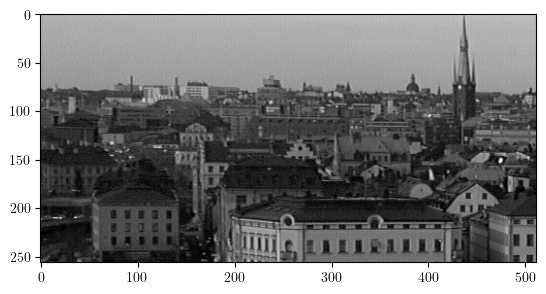

In [51]:
cmap = "gray"
plt.imshow(R_Y, cmap=cmap)

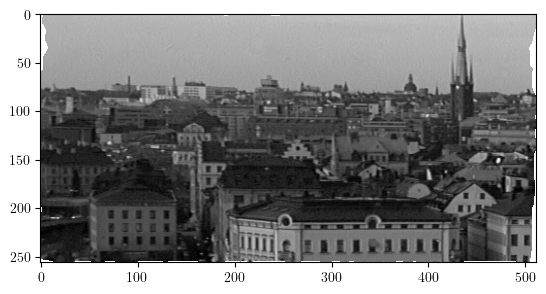

In [52]:
plt.imshow(f2_w, cmap=cmap)

## Working with lines
Farneback requires at least 2 lines, that in this case are true lines extracted from the image.

In [53]:
# From row 100 to row 355 (both included), we take 3 columns that go from 100 to 102 (both included)
R = RGB_image.read(sequence + "003.png")[100:356,100:103]
P = RGB_image.read(sequence + "003.png")[100:356,104:107]
#P = np.roll(R, 2)

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0


In [54]:
R = np.swapaxes(R, 0, 1)
P = np.swapaxes(P, 0, 1)

In [55]:
R.shape

(3, 256, 3)

In [56]:
P.shape

(3, 256, 3)

In [57]:
R_Y = YUV.from_RGB(R.astype(np.int16))[..., 0]
P_Y = YUV.from_RGB(P.astype(np.int16))[..., 0]

In [58]:
print(R_Y, P_Y)

[[168 167 170 168 167 164 171 167 169 171 164 164 167 164 162 168 168 164
  168 162 162 165 165 161 161 160 160 162 163 162 160 163 164 154 162 158
  162 157 157 158 161 160 158 158 151 153 157 153 158 154 161 163 158 153
  154 156 150 150 146 153 150 143 148 154 149 147 152 145 147 142 145 141
  148 143 146 142 143 125  91  63  71  61  63  70  63  68  75  71  69  95
  102 103  96 101 108 109  61  57  62  91  82  76  72  65  64  57  60  57
   57  52  54  61  55  62  56  51  64  45  55  51  49  35  39  53  45  30
   34  40  37  36  29  36  41  29  33  26  29  33  29  31  19  24  16  23
   29  25  35  30  23  39  26  24  35  35  28  50  31  44  44  55  49  38
   43  34  37  42  35  37  39  37  43  41  23  33  40  68  58  43  56  65
   64  56  49  70  77  53  41  42  39  43  33  42  34  46  47  49  43  32
   14   4   9   8  14  16  18  15  25  21  36  49  49 245 195  37  40  49
   51  43  41  52  30  11  14  18  11   1   6   3   8  15  16  14  11  14
   23  21  32  23  15  18  29  38  40 

In [59]:
print(R_Y.shape, P_Y.shape)

(3, 256) (3, 256)


In [60]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs, wside=3)

In [61]:
print(np.max(MVs), np.min(MVs))

0.50213027 -1.3140433


In [62]:
R_Y.shape

(3, 256)

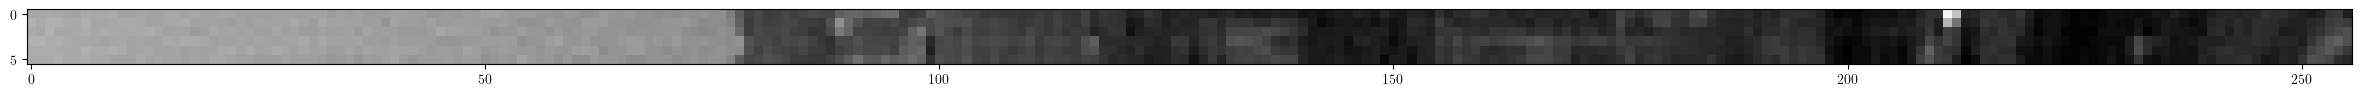

In [63]:
#gray_image.show(np.stack([R_Y, R_Y, R_Y, P_Y, P_Y, P_Y]), size=(30,10))
gray_image.show(np.stack([R_Y, P_Y], axis=0).reshape(6, 256), size=(30,10))


In [64]:
MVs.shape

(3, 256, 2)

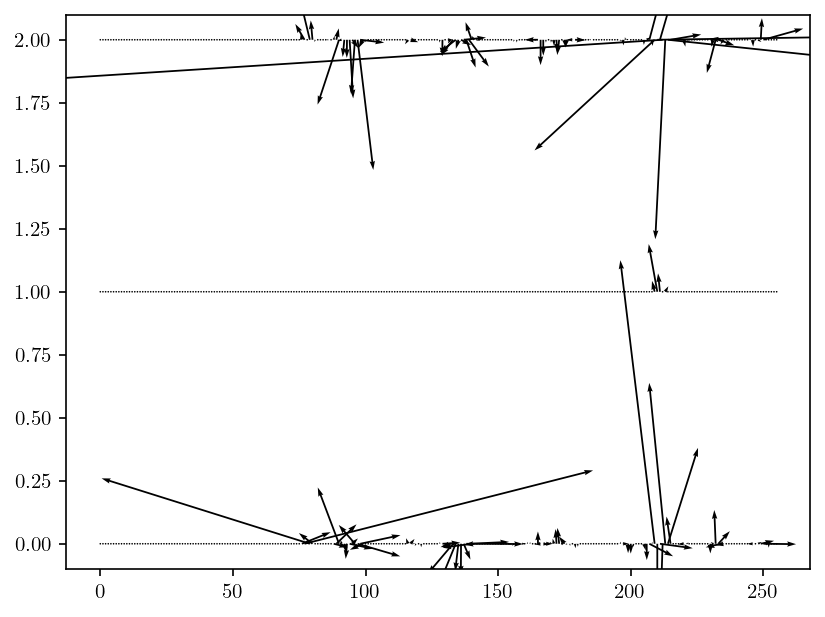

In [65]:
display.show_vectors(MVs)

[image_3.py:39 read() INFO] /tmp/original_003.png (768, 1280, 3) uint8 len=1927644 max=255 min=0
[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=90.1632568359375
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=78.77437642415364
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=67.62569783528646


uint8


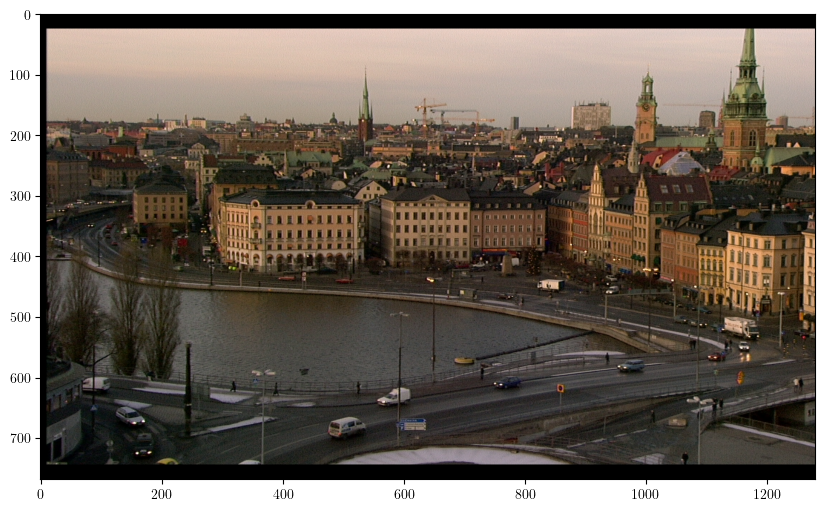

In [444]:
img = RGB_image.read(sequence + "003.png")
RGB_image.show(img,"")
print(img.dtype)

In [476]:
def filter_AAABBB(Y_img):
    # Iterate over rows
    total_flow_through_rows = []
    flow = np.zeros((3, Y_img.shape[1], 2), dtype=np.float32)
    for y in range(Y_img.shape[0]-1):
        prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #prev = np.stack([Y_img[y], Y_img[y+1], Y_img[y]])
        next = np.stack([Y_img[y+1], Y_img[y+1], Y_img[y+1]])
        #print(prev)
        if y==10:
            print(prev.shape, next.shape, flow.shape)
            print(np.max(prev), np.max(next))
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_rows.append(flow[1])
    # Iterate over columns
    total_flow_through_cols = []
    flow = np.zeros((3, Y_img.shape[0], 2), dtype=np.float32)
    for x in range(Y_img.shape[1]-1):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, x+1], Y_img[:, x+1], Y_img[:, x+1]])
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_cols.append(flow[1])
    return np.stack(total_flow_through_rows), np.stack(total_flow_through_cols)

def filter_AAABBB(Y_img):
    print(np.average(Y_img))
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((3, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        #prev = np.stack([Y_img[y], Y_img[(y+1)%N_rows], Y_img[(y+2)%N_rows]])
        #next = np.stack([Y_img[(y+3)%N_rows], Y_img[(y+4)%N_rows], Y_img[(y+5)%N_rows]])
        prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #next = np.stack([Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows]])
        next = np.roll(prev, 1, axis=1)
        print(prev)
        print(next)
        #print(prev)
        #if y==10:
        #    print(prev.shape, next.shape, flow[1].shape)
        #    print(np.max(prev), np.max(next))
        #    print(np.max(Y_img[y]), np.max(Y_img))
        #    print(prev, next)
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=prev_flow, wside=3)
        #prev_flow = flow.copy()
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        print(c, np.max(np.abs(flow[2][..., 0])), np.max(np.abs(flow[2][..., 1]))); c += 1
        #print(flow.shape)
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        total_flow_rows_pass.append(flow[1][..., 0])
        #print(flow[0], total_flow_rows_pass)
        max = 0
        for i in total_flow_rows_pass:
            _max = np.max(np.abs(i))
            if _max > max:
                max = _max
        #print("max=", max)
    #print(len(total_flow_rows_pass))
    #print(total_flow_rows_pass)
    #for i in total_flow_rows_pass:
    #    if np.max(np.abs(i)) != 0.0:
    #        print("!", end='')
    total_flow_rows_pass = np.array(total_flow_rows_pass).reshape(Y_img.shape)
    #total_flow_rows_pass = np.stack(total_flow_rows_pass)
    #print("max=", np.max(np.abs(total_flow_rows_pass)))
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((3, Y_img.shape[0], 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols]])
        #prev = np.stack([Y_img[:, x], Y_img[:, (x+1)%N_cols], Y_img[:, (x+2)%N_cols]])
        #next = np.stack([Y_img[:, (x+3)%N_cols], Y_img[:, (x+4)%N_cols], Y_img[:, (x+4)%N_cols]])
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_cols_pass.append(flow[1][..., 1])
    #total_flow_cols_pass = np.stack(total_flow_cols_pass)
    total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

In [477]:
Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:105,100:107])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:125])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:225,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:625,100:625])
#flow_rows, flow_cols = filter_AAABBB(Y_img[10:758,10:1270])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:668,100:1180])
flow_rows, flow_cols = filter_AAABBB(Y_img[40:740,40:1170])
#flow_rows, flow_cols = filter_AAABBB(Y_img)

82.10360682680151
[[191 195 200 ... 140 140 145]
 [191 195 200 ... 140 140 145]
 [191 195 200 ... 140 140 145]]
[[145 191 195 ... 143 140 140]
 [145 191 195 ... 143 140 140]
 [145 191 195 ... 143 140 140]]
0 3.64289e-12 0.0
[[196 196 200 ... 138 146 138]
 [196 196 200 ... 138 146 138]
 [196 196 200 ... 138 146 138]]
[[138 196 196 ... 137 138 146]
 [138 196 196 ... 137 138 146]
 [138 196 196 ... 137 138 146]]
1 4.8751732e-11 0.0
[[199 199 193 ... 138 146 140]
 [199 199 193 ... 138 146 140]
 [199 199 193 ... 138 146 140]]
[[140 199 199 ... 135 138 146]
 [140 199 199 ... 135 138 146]
 [140 199 199 ... 135 138 146]]
2 4.895405e-11 0.0
[[199 195 195 ... 136 135 137]
 [199 195 195 ... 136 135 137]
 [199 195 195 ... 136 135 137]]
[[137 199 195 ... 132 136 135]
 [137 199 195 ... 132 136 135]
 [137 199 195 ... 132 136 135]]
3 1.3888385e-11 0.0
[[195 196 197 ... 137 134 137]
 [195 196 197 ... 137 134 137]
 [195 196 197 ... 137 134 137]]
[[137 195 196 ... 133 137 134]
 [137 195 196 ... 133 137 13

162 1.4690476e-11 0.0
[[96 99 91 ... 72 61 68]
 [96 99 91 ... 72 61 68]
 [96 99 91 ... 72 61 68]]
[[68 96 99 ... 68 72 61]
 [68 96 99 ... 68 72 61]
 [68 96 99 ... 68 72 61]]
163 6.16195e-12 0.0
[[85 96 85 ... 70 59 70]
 [85 96 85 ... 70 59 70]
 [85 96 85 ... 70 59 70]]
[[70 85 96 ... 66 70 59]
 [70 85 96 ... 66 70 59]
 [70 85 96 ... 66 70 59]]
164 6.17853e-12 0.0
[[36 37 43 ... 61 62 72]
 [36 37 43 ... 61 62 72]
 [36 37 43 ... 61 62 72]]
[[72 36 37 ... 63 61 62]
 [72 36 37 ... 63 61 62]
 [72 36 37 ... 63 61 62]]
165 1.8343266e-11 0.0
[[44 39 39 ... 61 49 68]
 [44 39 39 ... 61 49 68]
 [44 39 39 ... 61 49 68]]
[[68 44 39 ... 66 61 49]
 [68 44 39 ... 66 61 49]
 [68 44 39 ... 66 61 49]]
166 1.1988792e-11 0.0
[[31 45 37 ... 55 58 65]
 [31 45 37 ... 55 58 65]
 [31 45 37 ... 55 58 65]]
[[65 31 45 ... 60 55 58]
 [65 31 45 ... 60 55 58]
 [65 31 45 ... 60 55 58]]
167 7.927523e-12 0.0
[[30 28 32 ... 63 66 84]
 [30 28 32 ... 63 66 84]
 [30 28 32 ... 63 66 84]]
[[84 30 28 ... 73 63 66]
 [84 30 28 .

260 5.8525272e-12 0.0
[[56 51 49 ... 30 28 30]
 [56 51 49 ... 30 28 30]
 [56 51 49 ... 30 28 30]]
[[30 56 51 ... 31 30 28]
 [30 56 51 ... 31 30 28]
 [30 56 51 ... 31 30 28]]
261 1.9379717e-11 0.0
[[56 50 50 ... 27 25 25]
 [56 50 50 ... 27 25 25]
 [56 50 50 ... 27 25 25]]
[[25 56 50 ... 25 27 25]
 [25 56 50 ... 25 27 25]
 [25 56 50 ... 25 27 25]]
262 5.433055e-12 0.0
[[52 44 47 ... 24 19 17]
 [52 44 47 ... 24 19 17]
 [52 44 47 ... 24 19 17]]
[[17 52 44 ... 26 24 19]
 [17 52 44 ... 26 24 19]
 [17 52 44 ... 26 24 19]]
263 9.242343e-12 0.0
[[35 35 41 ... 32 33 25]
 [35 35 41 ... 32 33 25]
 [35 35 41 ... 32 33 25]]
[[25 35 35 ... 17 32 33]
 [25 35 35 ... 17 32 33]
 [25 35 35 ... 17 32 33]]
264 4.7221654e-12 0.0
[[33 34 29 ... 36 31 25]
 [33 34 29 ... 36 31 25]
 [33 34 29 ... 36 31 25]]
[[25 33 34 ... 23 36 31]
 [25 33 34 ... 23 36 31]
 [25 33 34 ... 23 36 31]]
265 1.3110922e-11 0.0
[[36 37 36 ... 25 24 22]
 [36 37 36 ... 25 24 22]
 [36 37 36 ... 25 24 22]]
[[22 36 37 ... 17 25 24]
 [22 36 3

[[ 64  67  65 ... 105  85  71]
 [ 64  67  65 ... 105  85  71]
 [ 64  67  65 ... 105  85  71]]
[[ 71  64  67 ... 138 105  85]
 [ 71  64  67 ... 138 105  85]
 [ 71  64  67 ... 138 105  85]]
338 1.0007659e-11 0.0
[[ 49  51  57 ... 104  75  69]
 [ 49  51  57 ... 104  75  69]
 [ 49  51  57 ... 104  75  69]]
[[ 69  49  51 ... 134 104  75]
 [ 69  49  51 ... 134 104  75]
 [ 69  49  51 ... 134 104  75]]
339 1.2812056e-11 0.0
[[ 46  52  69 ... 103  70  72]
 [ 46  52  69 ... 103  70  72]
 [ 46  52  69 ... 103  70  72]]
[[ 72  46  52 ... 140 103  70]
 [ 72  46  52 ... 140 103  70]
 [ 72  46  52 ... 140 103  70]]
340 3.5728677e-11 0.0
[[46 47 50 ... 99 76 73]
 [46 47 50 ... 99 76 73]
 [46 47 50 ... 99 76 73]]
[[ 73  46  47 ... 134  99  76]
 [ 73  46  47 ... 134  99  76]
 [ 73  46  47 ... 134  99  76]]
341 4.6764863e-11 0.0
[[ 57  57  56 ... 107  67  84]
 [ 57  57  56 ... 107  67  84]
 [ 57  57  56 ... 107  67  84]]
[[ 84  57  57 ... 139 107  67]
 [ 84  57  57 ... 139 107  67]
 [ 84  57  57 ... 139 

[[102  94  92 ...  58  65 100]
 [102  94  92 ...  58  65 100]
 [102  94  92 ...  58  65 100]]
[[100 102  94 ...  61  58  65]
 [100 102  94 ...  61  58  65]
 [100 102  94 ...  61  58  65]]
404 4.926361e-11 0.0
[[ 99  97  87 ... 110  97 116]
 [ 99  97  87 ... 110  97 116]
 [ 99  97  87 ... 110  97 116]]
[[116  99  97 ... 127 110  97]
 [116  99  97 ... 127 110  97]
 [116  99  97 ... 127 110  97]]
405 2.3696302e-11 0.0
[[ 89  92  89 ... 154 144 139]
 [ 89  92  89 ... 154 144 139]
 [ 89  92  89 ... 154 144 139]]
[[139  89  92 ... 158 154 144]
 [139  89  92 ... 158 154 144]
 [139  89  92 ... 158 154 144]]
406 4.059056e-11 0.0
[[ 70  76  78 ... 165 161 146]
 [ 70  76  78 ... 165 161 146]
 [ 70  76  78 ... 165 161 146]]
[[146  70  76 ... 160 165 161]
 [146  70  76 ... 160 165 161]
 [146  70  76 ... 160 165 161]]
407 1.1110154e-11 0.0
[[ 69  81  84 ... 157 165 156]
 [ 69  81  84 ... 157 165 156]
 [ 69  81  84 ... 157 165 156]]
[[156  69  81 ... 162 157 165]
 [156  69  81 ... 162 157 165]
 [156 

[[45 43 47 ... 64 54 50]
 [45 43 47 ... 64 54 50]
 [45 43 47 ... 64 54 50]]
[[50 45 43 ... 91 64 54]
 [50 45 43 ... 91 64 54]
 [50 45 43 ... 91 64 54]]
463 7.775555e-12 0.0
[[ 54  40  30 ... 137 137 120]
 [ 54  40  30 ... 137 137 120]
 [ 54  40  30 ... 137 137 120]]
[[120  54  40 ... 130 137 137]
 [120  54  40 ... 130 137 137]
 [120  54  40 ... 130 137 137]]
464 1.134438e-11 0.0
[[ 47  47  36 ... 144 144 148]
 [ 47  47  36 ... 144 144 148]
 [ 47  47  36 ... 144 144 148]]
[[148  47  47 ... 138 144 144]
 [148  47  47 ... 138 144 144]
 [148  47  47 ... 138 144 144]]
465 1.8274401e-11 0.0
[[ 47  40  38 ... 121 135 131]
 [ 47  40  38 ... 121 135 131]
 [ 47  40  38 ... 121 135 131]]
[[131  47  40 ... 118 121 135]
 [131  47  40 ... 118 121 135]
 [131  47  40 ... 118 121 135]]
466 2.922429e-11 0.0
[[ 45  42  26 ... 110 121 134]
 [ 45  42  26 ... 110 121 134]
 [ 45  42  26 ... 110 121 134]]
[[134  45  42 ... 131 110 121]
 [134  45  42 ... 131 110 121]
 [134  45  42 ... 131 110 121]]
467 1.16444

[[48 55 41 ...  2  2  9]
 [48 55 41 ...  2  2  9]
 [48 55 41 ...  2  2  9]]
[[ 9 48 55 ...  2  2  2]
 [ 9 48 55 ...  2  2  2]
 [ 9 48 55 ...  2  2  2]]
516 8.5184886e-13 0.0
[[56 66 49 ... 14 12  9]
 [56 66 49 ... 14 12  9]
 [56 66 49 ... 14 12  9]]
[[ 9 56 66 ... 12 14 12]
 [ 9 56 66 ... 12 14 12]
 [ 9 56 66 ... 12 14 12]]
517 1.5839166e-12 0.0
[[51 42 38 ... 42 40 27]
 [51 42 38 ... 42 40 27]
 [51 42 38 ... 42 40 27]]
[[27 51 42 ... 28 42 40]
 [27 51 42 ... 28 42 40]
 [27 51 42 ... 28 42 40]]
518 1.7156306e-12 0.0
[[47 49 49 ... 46 57 65]
 [47 49 49 ... 46 57 65]
 [47 49 49 ... 46 57 65]]
[[65 47 49 ... 48 46 57]
 [65 47 49 ... 48 46 57]
 [65 47 49 ... 48 46 57]]
519 1.8310902e-12 0.0
[[31 29 34 ... 63 83 92]
 [31 29 34 ... 63 83 92]
 [31 29 34 ... 63 83 92]]
[[92 31 29 ... 64 63 83]
 [92 31 29 ... 64 63 83]
 [92 31 29 ... 64 63 83]]
520 2.1402285e-12 0.0
[[ 36  37  38 ...  92 125 142]
 [ 36  37  38 ...  92 125 142]
 [ 36  37  38 ...  92 125 142]]
[[142  36  37 ...  76  92 125]
 [142

[[36 35 38 ... 74 77 77]
 [36 35 38 ... 74 77 77]
 [36 35 38 ... 74 77 77]]
[[77 36 35 ... 76 74 77]
 [77 36 35 ... 76 74 77]
 [77 36 35 ... 76 74 77]]
565 6.311458e-12 0.0
[[40 36 43 ... 70 77 60]
 [40 36 43 ... 70 77 60]
 [40 36 43 ... 70 77 60]]
[[60 40 36 ... 69 70 77]
 [60 40 36 ... 69 70 77]
 [60 40 36 ... 69 70 77]]
566 4.2758488e-12 0.0
[[39 47 52 ... 59 67 65]
 [39 47 52 ... 59 67 65]
 [39 47 52 ... 59 67 65]]
[[65 39 47 ... 52 59 67]
 [65 39 47 ... 52 59 67]
 [65 39 47 ... 52 59 67]]
567 2.258433e-12 0.0
[[42 45 40 ... 64 66 66]
 [42 45 40 ... 64 66 66]
 [42 45 40 ... 64 66 66]]
[[66 42 45 ... 60 64 66]
 [66 42 45 ... 60 64 66]
 [66 42 45 ... 60 64 66]]
568 2.5696752e-12 0.0
[[50 44 37 ... 62 61 63]
 [50 44 37 ... 62 61 63]
 [50 44 37 ... 62 61 63]]
[[63 50 44 ... 63 62 61]
 [63 50 44 ... 63 62 61]
 [63 50 44 ... 63 62 61]]
569 1.9429769e-11 0.0
[[36 41 36 ... 66 60 56]
 [36 41 36 ... 66 60 56]
 [36 41 36 ... 66 60 56]]
[[56 36 41 ... 57 66 60]
 [56 36 41 ... 57 66 60]
 [56 3

[[49 42 31 ... 63 64 56]
 [49 42 31 ... 63 64 56]
 [49 42 31 ... 63 64 56]]
[[56 49 42 ... 63 63 64]
 [56 49 42 ... 63 63 64]
 [56 49 42 ... 63 63 64]]
654 8.4213187e-13 0.0
[[52 53 52 ... 57 56 61]
 [52 53 52 ... 57 56 61]
 [52 53 52 ... 57 56 61]]
[[61 52 53 ... 59 57 56]
 [61 52 53 ... 59 57 56]
 [61 52 53 ... 59 57 56]]
655 3.9497892e-13 0.0
[[58 63 61 ... 61 62 62]
 [58 63 61 ... 61 62 62]
 [58 63 61 ... 61 62 62]]
[[62 58 63 ... 65 61 62]
 [62 58 63 ... 65 61 62]
 [62 58 63 ... 65 61 62]]
656 7.864837e-13 0.0
[[59 65 59 ... 69 73 65]
 [59 65 59 ... 69 73 65]
 [59 65 59 ... 69 73 65]]
[[65 59 65 ... 69 69 73]
 [65 59 65 ... 69 69 73]
 [65 59 65 ... 69 69 73]]
657 1.3415804e-12 0.0
[[63 58 33 ... 82 72 68]
 [63 58 33 ... 82 72 68]
 [63 58 33 ... 82 72 68]]
[[68 63 58 ... 79 82 72]
 [68 63 58 ... 79 82 72]
 [68 63 58 ... 79 82 72]]
658 7.122075e-13 0.0
[[60 45 37 ... 71 71 63]
 [60 45 37 ... 71 71 63]
 [60 45 37 ... 71 71 63]]
[[63 60 45 ... 68 71 71]
 [63 60 45 ... 68 71 71]
 [63 6

In [460]:
flow_rows.shape

(700, 1130)

In [461]:
flow_cols.shape

(700, 1130)

In [462]:
np.max(flow_rows)

3.9039034e-14

In [463]:
768*1280

983040

In [464]:
np.min(flow_rows)

-4.2136227e-14

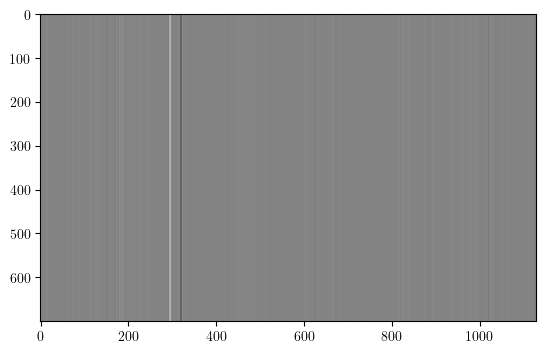

In [465]:
matplotlib.pyplot.imshow(X=flow_rows, cmap="gray")

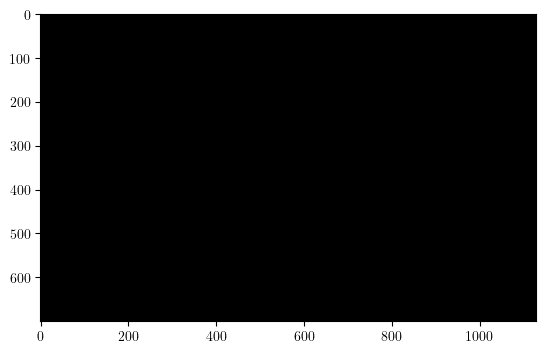

In [416]:
matplotlib.pyplot.imshow(X=flow_cols, cmap="gray")

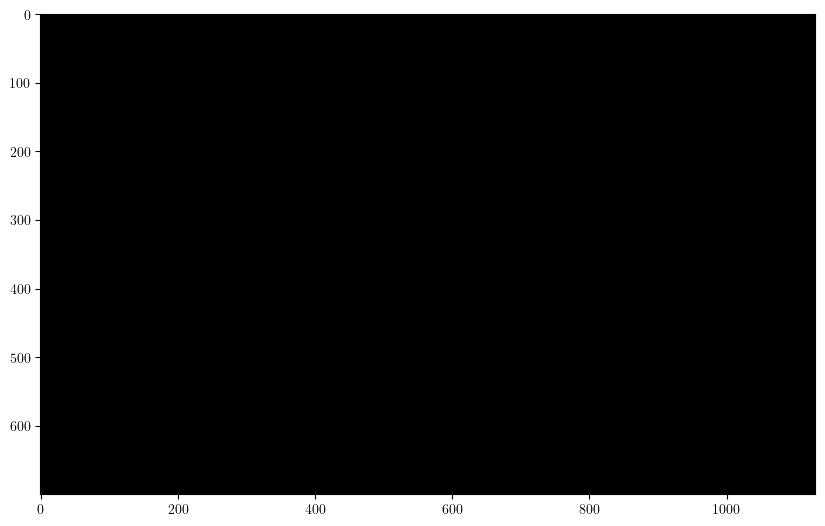

In [216]:
gray_image.show(flow_rows*255,"")

ValueError: Argument U has a size 4 which does not match 1, the number of arrow positions

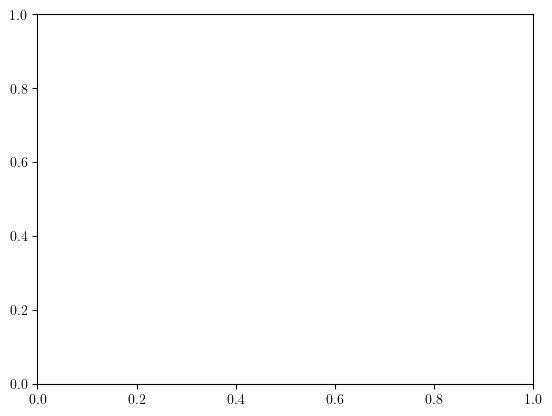

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# create an array of vectors
vectors = np.array([[1, 2], [2, 1], [0, 3], [3, 0]])

# plot the vectors
origin = [0], [0]  # origin point
plt.quiver(*origin, vectors[:, 0], vectors[:, 1], color=['r', 'b', 'g', 'y'], scale=10)
plt.axis('equal')   # set the aspect ratio to 'equal'
plt.show()

## Working with 1-d lines

In [ ]:
R_Y_line = R_Y[..., 1]
P_Y_line = P_Y[..., 2]

In [ ]:
print(R_Y_line.shape,P_Y_line.shape)

In [ ]:
R = np.stack([np.roll(R_Y_line,-1), R_Y_line, np.roll(R_Y_line,1)])
P = np.stack([np.roll(P_Y_line,-1), P_Y_line, np.roll(P_Y_line,1)])

In [ ]:
print(R.shape, P.shape)

In [ ]:
for i in range(10):
    print(R[0, i], R[1, i])

In [ ]:
for i in range(10):
    print(P[0, i], P[1, i])

In [ ]:
for i in range(10):
    print(R[0, i], P[1, i])

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs, wside=3)

In [ ]:
#print(np.max(MVs[1]), np.min(MVs[1]), np.argmax(MVs[1]), MVs[np.argmax(MVs[1])])
print(np.max(MVs[1]), np.min(MVs[1]), len(MVs[1]), np.argmax(MVs[1]))

In [ ]:
for i in range(P.shape[1]):
    print(i, R[1, i], P[1, i], MVs[1, i])

In [ ]:
line = np.arange(4).astype(np.int16)
block = np.stack([line, line, line, line])
print(block)
#block = np.arange(16).astype(np.int16).reshape(4, 4)
c = np.ones_like(block)
A, B, C = poly_exp(block, c, sigma=1.0)

## Farneback 1D

In [ ]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of pixel i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Kernel applicability
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", x)
    a = np.exp(-(x**2) / (2 * sigma**2))
    print("a =", a)

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    print("b =", b)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("f =", f)
    print("c =", c)
    print("cf =", cf)
    

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [b.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [b.shape[-1]])

    #G = np.empty(list(f.shape))
    #v = np.empty(list(f.shape))
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b) # a[i]*b[i,j] -> ab[i,j]
    abb = np.einsum("ij,ik->ijk", ab, b) # ab[i,j]*b[i,k] -> abb[i,j,k]
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(b.shape[-1]):
        for j in range(b.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )
    #for j in range(b.shape[-1]):
    #    G[..., j] = scipy.ndimage.correlate1d(
    #        c, abb[..., j], axis=0, mode="constant", cval=0
    #    )
    print("G =", G)
    print("v =", v)

    #v = scipy.ndimage.correlate1d(
    #    cf, ab, axis=0, mode="constant", cval=0
    #)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)
    print("r =", r)

    # Quadratic term
    #A = np.empty(list(f.shape))
    A = np.empty(list(f.shape)  + [1])
    A[..., 0] = r[..., 2]
    print("A =", A)

    # Linear term
    #B = np.empty(list(f.shape))
    B = np.empty(list(f.shape) + [1])
    B[..., 0] = r[..., 1]
    print("B =", B)

    # constant term
    C = r[..., 0]
    print("C =", C)

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)
    return A, B, C


In [ ]:
line = np.arange(4).astype(np.int16)
c = np.ones_like(line)
A, B, C = poly_exp_1D(line, c, sigma=1.0)

In [ ]:
def flow_iterative_1D(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the lines
    A1, B1, C1 = poly_exp_1D(f1, c1, sigma)
    A2, B2, C2 = poly_exp_1D(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.arange(f1.shape[0]).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [1])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        print(x_.shape, np.array(f1.shape))
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
sigma = 1.0
c1 = np.ones_like(f1)
c2 = np.ones_like(f2)
sigma_flow = 1.0
flow_iterative_1D(f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None)

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
x = np.stack(np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])), axis=-1,).astype(np.int32)

In [ ]:
print(x)

In [ ]:
np.eye(2).swapaxes(-1, -2)

In [ ]:
c = np.ones_like(R_Y_line)
print(c.shape)
A, B, C = poly_exp_1D(R_Y_line, c, sigma=1.0)

In [ ]:
A_Y

In [ ]:
A_Y.shape

In [ ]:
B_Y.shape

In [ ]:
C_Y.shape